# Preprocessing Module with Features Data
This module adds the target column of laterality to features data according to
MDS-UPDRS patients test.

## Required Imports

In [78]:
import os
import re


import pandas as pd
import numpy as np
import seaborn as sns

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

## Load Data
Loads Features and MDS-UPDRS

In [20]:
#Load Features
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_features.pkl')

#Load MDS-UPDRS
patients_mds: pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'imus y marcha (1).xlsx')
patients_mds_used_columns = ['CC','Laterality']
patients_mds = patients_mds[patients_mds_used_columns]

In [21]:
patients_mds.dropna(inplace=True)

In [24]:
patients_mds['CC'] = patients_mds['CC'].astype(int)
patients_mds['CC'] = patients_mds['CC'].astype('string')
patients_mds['Laterality'] = patients_mds['Laterality'].astype(int)

## MDS-UPDRS Target extraction

Is necessary to split patients and controls to cross ids with MDS-UPDRS test:

In [27]:
patients_mds['anon_id'] = patients_mds['CC'].apply(get_anon_id)
patients_mds_used_columns.pop(0)

'CC'

In [29]:
patients_mds.dropna(inplace=True)

In [31]:
patients_mds['laterality'] = patients_mds['Laterality']
patients_mds = patients_mds[['anon_id', 'laterality']]

In [32]:
patients_mds = patients_mds[patients_mds['anon_id'].ne('')]

In [33]:
patients_mds

,anon_id,laterality
0,182,1
1,176,1
2,184,2
3,67,2
6,173,1
...,...,...
127,85,1
128,68,0
135,14,1
149,92,0


In [34]:
patients_mds['laterality'].value_counts()

laterality
1    50
2    42
0    10
Name: count, dtype: int64

In [35]:
patients = data[data['PD'] == 1].copy()
controls = data[data['PD'] == 0].copy()

In [36]:
len(patients)

10284

In [37]:
mds_id_list = set(patients_mds['anon_id'].tolist())
df_id_list = set(patients['anon_id'].tolist())
intersection_ids = df_id_list.intersection(mds_id_list)
print(len(intersection_ids))

78


In [38]:
patients_mds = patients_mds[patients_mds['anon_id'].isin(intersection_ids)]

In [39]:
print('Patients registers before merge:',len(patients))
patients = pd.merge(patients, patients_mds, how='inner')
patients.dropna(inplace=True)
print('Patients registers after merge:',len(patients))

Patients registers before merge: 10284
Patients registers after merge: 10280


In [40]:
controls['laterality'] = [0 for i in range(len(controls))]

In [41]:
laterality_data = pd.concat([patients, controls])

In [42]:
len(laterality_data)

19746

In [43]:
laterality_data['laterality'].value_counts()

laterality
0    10686
1     5105
2     3955
Name: count, dtype: int64

## Feature Selection

In [47]:
temp = laterality_data[laterality_data.columns.tolist()[4:]].copy()

In [48]:
correlation = laterality_data[laterality_data.columns.tolist()[4:]].corr().abs()['laterality']

In [57]:
correlation

imu_gyroX_right_mean                     0.002262
imu_gyroX_right_std                      0.038539
imu_gyroX_right_mean_abs_dev             0.032201
imu_gyroX_right_min                      0.046075
imu_gyroX_right_max                      0.056789
                                           ...   
imu_angularZ_spine_local_maxima_count    0.252458
imu_angularZ_spine_skewness              0.012433
imu_angularZ_spine_kurtosis              0.071358
PD                                       0.799869
laterality                               1.000000
Name: laterality, Length: 542, dtype: float64

In [58]:
best_correlations_columns = []
for index, value in correlation.items():
    if value > 0.27:
        best_correlations_columns.append(index)

best_correlations_columns

['imu_gyroZ_left_std',
 'imu_gyroZ_left_mean_abs_dev',
 'imu_gyroZ_left_min',
 'imu_gyroZ_left_range',
 'imu_gyroZ_left_median_abs_dev',
 'imu_gyroZ_left_interquartile_range',
 'imu_gyroZ_spine_std',
 'imu_gyroZ_spine_mean_abs_dev',
 'imu_gyroZ_spine_median_abs_dev',
 'imu_gyroZ_spine_interquartile_range',
 'imu_angleX_left_std',
 'imu_angleX_left_mean_abs_dev',
 'imu_angleZ_left_std',
 'imu_angleZ_left_mean_abs_dev',
 'imu_angleZ_left_min',
 'imu_angleZ_left_max',
 'imu_angleZ_left_range',
 'imu_angleZ_left_median_abs_dev',
 'imu_angleZ_left_interquartile_range',
 'PD',
 'laterality']

In [59]:
len(best_correlations_columns)

21

<Axes: >

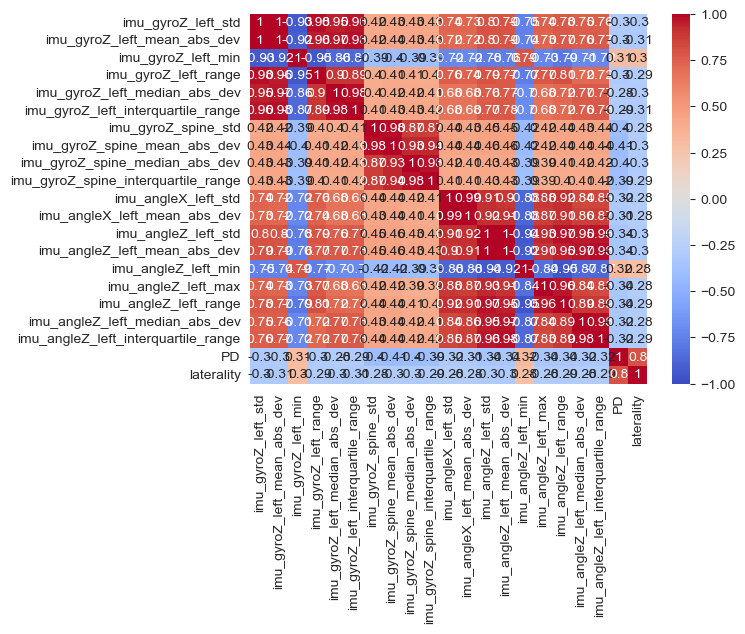

In [62]:
laterality_data = laterality_data[best_correlations_columns]
sns.heatmap(laterality_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Drop of highly correlated columns

In [63]:
correlation = laterality_data.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['imu_gyroZ_left_mean_abs_dev',
 'imu_gyroZ_left_range',
 'imu_gyroZ_left_median_abs_dev',
 'imu_gyroZ_left_interquartile_range',
 'imu_gyroZ_spine_mean_abs_dev',
 'imu_gyroZ_spine_interquartile_range',
 'imu_angleX_left_mean_abs_dev',
 'imu_angleZ_left_mean_abs_dev',
 'imu_angleZ_left_range',
 'imu_angleZ_left_median_abs_dev',
 'imu_angleZ_left_interquartile_range']

In [66]:
correlation['laterality'].sort_values()

imu_angleX_left_mean_abs_dev           0.275638
imu_angleX_left_std                    0.276557
imu_gyroZ_spine_std                    0.278349
imu_angleZ_left_max                    0.279167
imu_angleZ_left_min                    0.284159
imu_angleZ_left_median_abs_dev         0.284477
imu_gyroZ_left_range                   0.287656
imu_gyroZ_spine_interquartile_range    0.290444
imu_angleZ_left_interquartile_range    0.291757
imu_angleZ_left_range                  0.293437
imu_gyroZ_spine_mean_abs_dev           0.295124
imu_gyroZ_left_median_abs_dev          0.295763
imu_gyroZ_spine_median_abs_dev         0.296932
imu_gyroZ_left_min                     0.299594
imu_angleZ_left_mean_abs_dev           0.302290
imu_angleZ_left_std                    0.303162
imu_gyroZ_left_std                     0.303236
imu_gyroZ_left_interquartile_range     0.308214
imu_gyroZ_left_mean_abs_dev            0.308716
PD                                     0.799869
laterality                             1

In [64]:
len(to_drop)

11

In [67]:
laterality_data.drop(to_drop, axis=1, inplace=True)

In [68]:
#PD is not the target of this module so it will be deleted
laterality_data.drop(columns=['PD'], inplace=True)

<Axes: >

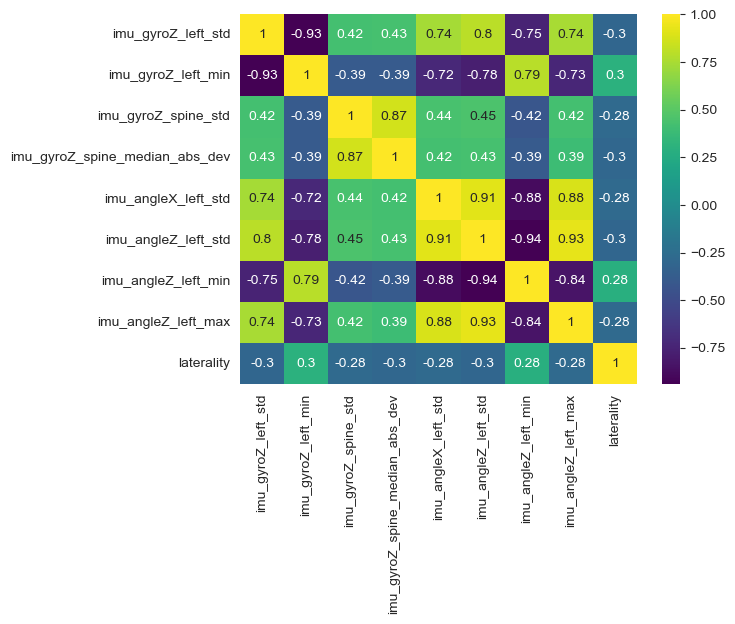

In [69]:
sns.heatmap(laterality_data.corr(), annot = True, cmap= 'viridis')

## Features Mirroring
Due to the chosen features only focused on left limb and spine, is necessary to keep on mind that a patient could
have laterality on his right limb and using the selected features is not possible to identify that PD symptom. As
an alternative for this problem we will add all the symmetric features (if mean_left is present, then mean_right 
will also be included)

In [74]:
pattern_left = re.compile(".*.left")
left_cols = list(filter(pattern_left.match, laterality_data.columns.tolist()))
right_cols = [col.replace('left', 'right') for col in left_cols]

for col in right_cols:
    laterality_data[col] = temp[col]

In [75]:
laterality_data.columns

Index(['imu_gyroZ_left_std', 'imu_gyroZ_left_min', 'imu_gyroZ_spine_std',
       'imu_gyroZ_spine_median_abs_dev', 'imu_angleX_left_std',
       'imu_angleZ_left_std', 'imu_angleZ_left_min', 'imu_angleZ_left_max',
       'laterality', 'imu_gyroZ_right_std', 'imu_gyroZ_right_min',
       'imu_angleX_right_std', 'imu_angleZ_right_std', 'imu_angleZ_right_min',
       'imu_angleZ_right_max'],
      dtype='object')

In [76]:
laterality_col = laterality_data.pop('laterality')
laterality_data.insert(len(laterality_data.columns), 'laterality', laterality_col)

<Axes: >

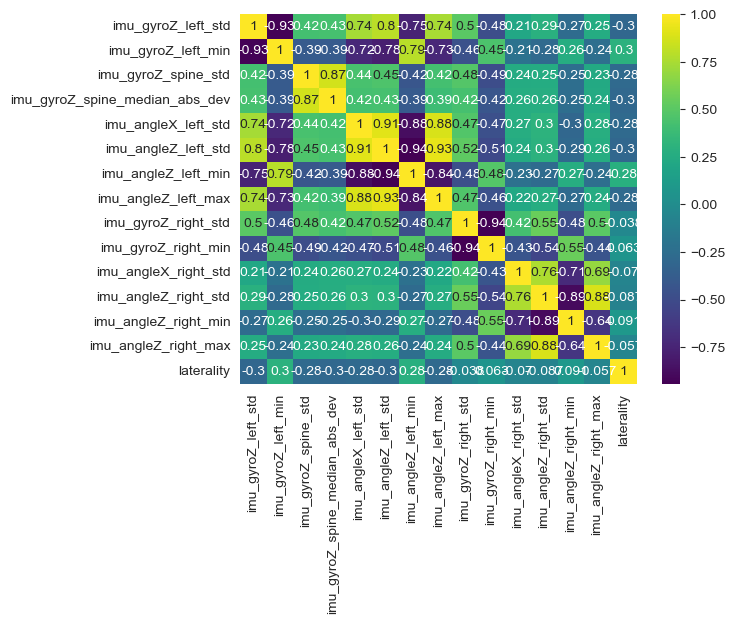

In [77]:
sns.heatmap(laterality_data.corr(), annot = True, cmap= 'viridis')

## Save data

In [79]:
save_path = str(ROOT_DIR) + '/data/processed/laterality-features/'
os.makedirs(save_path, exist_ok=True)

save_and_split(laterality_data, 'laterality-features')